Number of train samples: 2930
Number of validation samples: 366
Number of test samples: 366
There are 2930 training images.
There are 366 validation images.
There are 366 test images.


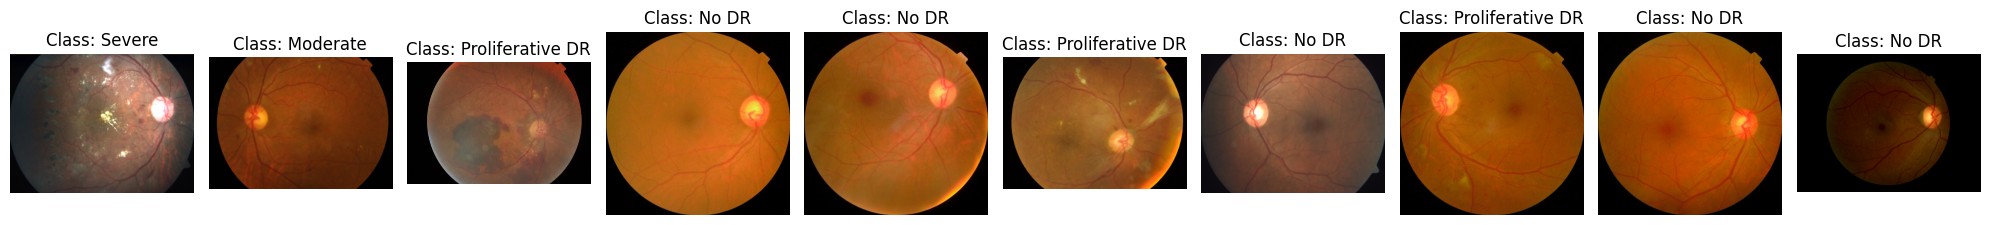

In [4]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.image as mpimg

warnings.filterwarnings("ignore")
# Load the CSV files
train_data = pd.read_csv("/kaggle/input/aptos2019/train_1.csv")
valid_data = pd.read_csv("/kaggle/input/aptos2019/valid.csv")
test_data = pd.read_csv("/kaggle/input/aptos2019/test.csv")

# Print the number of samples in each dataset
print('Number of train samples:', train_data.shape[0])
print('Number of validation samples:', valid_data.shape[0])
print('Number of test samples:', test_data.shape[0])


import os

# Define the image directories
train_image_dir = "/kaggle/input/aptos2019/train_images/train_images"
val_image_dir = "/kaggle/input/aptos2019/val_images/val_images"
test_image_dir = "/kaggle/input/aptos2019/test_images/test_images"

# Function to count images in a directory
def count_images(directory):
    return len([file for file in os.listdir(directory) if file.endswith(('.png', '.jpg', '.jpeg'))])

# Count images in each directory
train_image_count = count_images(train_image_dir)
val_image_count = count_images(val_image_dir)
test_image_count = count_images(test_image_dir)

# Print the counts
print(f'There are {train_image_count} training images.')
print(f'There are {val_image_count} validation images.')
print(f'There are {test_image_count} test images.')


import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

# Class labels dictionary
class_labels = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

# Check some random images from the training set to ensure they are correctly labeled
random_samples = random.sample(list(train_data['id_code']), 10)

plt.figure(figsize=(20, 10))
for i, image_id in enumerate(random_samples):
    # Image file path
    img_path = os.path.join(train_image_dir, f"{image_id}.png")  # Adjust extension if necessary
    img = mpimg.imread(img_path)
    
    # Get the class label for the image
    image_class = train_data.loc[train_data['id_code'] == image_id, 'diagnosis'].values[0]
    class_name = class_labels.get(image_class, "Unknown")
    
    # Plot the image
    plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {class_name}")

plt.tight_layout()
plt.show()

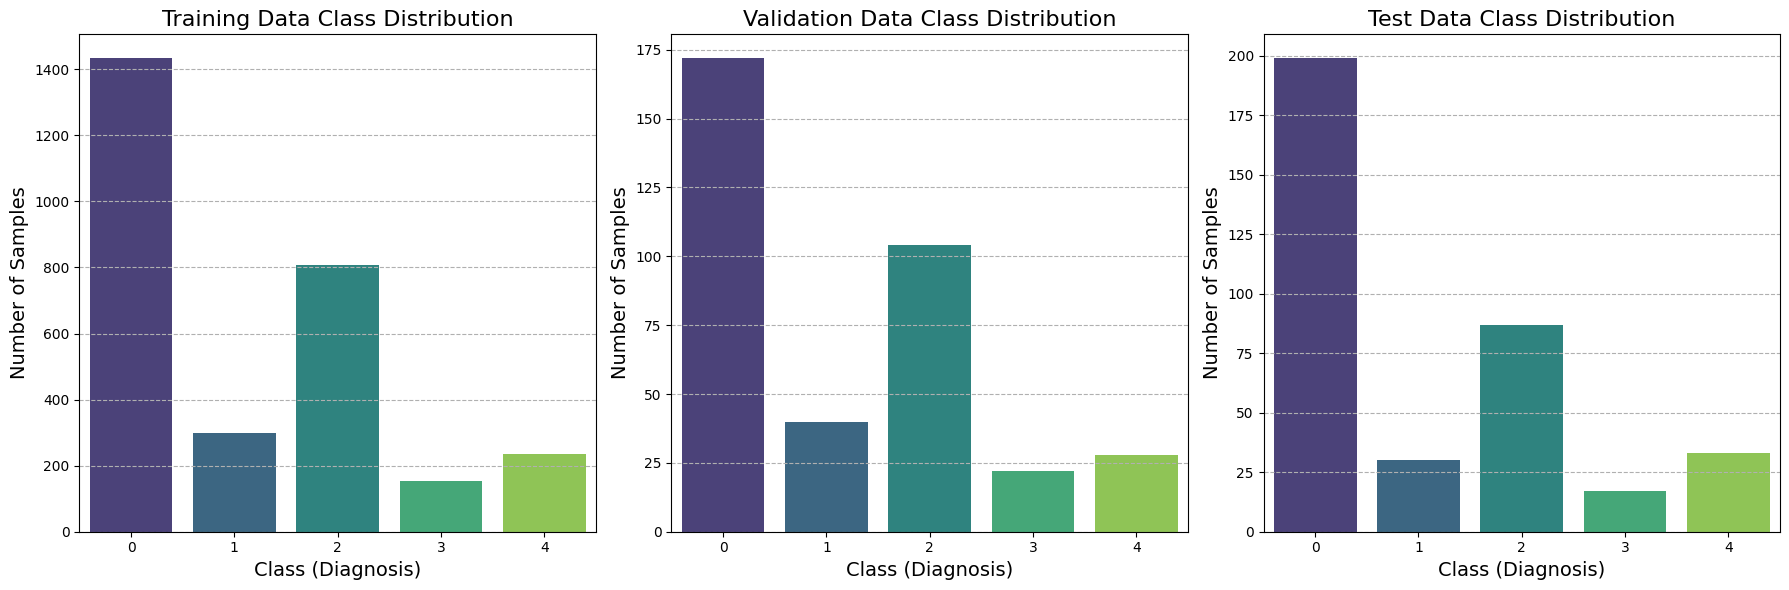

Training Data Class Distribution:
diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64

Validation Data Class Distribution:
diagnosis
0    172
1     40
2    104
3     22
4     28
Name: count, dtype: int64

Test Data Class Distribution:
diagnosis
0    199
1     30
2     87
3     17
4     33
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the CSV files (if not already loaded)
train_data = pd.read_csv("/kaggle/input/aptos2019/train_1.csv")
valid_data = pd.read_csv("/kaggle/input/aptos2019/valid.csv")
test_data = pd.read_csv("/kaggle/input/aptos2019/test.csv")

# Count the occurrences of each class in the training, validation, and test datasets
train_class_counts = train_data['diagnosis'].value_counts().sort_index()
val_class_counts = valid_data['diagnosis'].value_counts().sort_index()
test_class_counts = test_data['diagnosis'].value_counts().sort_index()

# Set up the bar charts for each dataset
plt.figure(figsize=(18, 6))

# Training Data
plt.subplot(1, 3, 1)
sns.barplot(x=train_class_counts.index, y=train_class_counts.values, palette='viridis')
plt.title('Training Data Class Distribution', fontsize=16)
plt.xlabel('Class (Diagnosis)', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(ticks=train_class_counts.index, labels=train_class_counts.index)
plt.grid(axis='y', linestyle='--')

# Validation Data
plt.subplot(1, 3, 2)
sns.barplot(x=val_class_counts.index, y=val_class_counts.values, palette='viridis')
plt.title('Validation Data Class Distribution', fontsize=16)
plt.xlabel('Class (Diagnosis)', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(ticks=val_class_counts.index, labels=val_class_counts.index)
plt.grid(axis='y', linestyle='--')

# Test Data
plt.subplot(1, 3, 3)
sns.barplot(x=test_class_counts.index, y=test_class_counts.values, palette='viridis')
plt.title('Test Data Class Distribution', fontsize=16)
plt.xlabel('Class (Diagnosis)', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(ticks=test_class_counts.index, labels=test_class_counts.index)
plt.grid(axis='y', linestyle='--')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print the number of samples for each class in the training data
print("Training Data Class Distribution:")
print(train_class_counts)
print("\nValidation Data Class Distribution:")
print(val_class_counts)
print("\nTest Data Class Distribution:")
print(test_class_counts)

In [6]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

# Define image dimensions and paths
IMG_SIZE = 100
train_image_dir = "/kaggle/input/aptos2019/train_images/train_images"

# Load CSV file
train_data = pd.read_csv("/kaggle/input/aptos2019/train_1.csv")

# Preprocess the images (this function remains unchanged)
def load_and_preprocess_image(image_id):
    img_path = os.path.join(train_image_dir, f"{image_id}.png")
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    return img_array

# Convert labels to numeric format and prepare features
X = np.array([load_and_preprocess_image(image_id) for image_id in train_data['id_code']])
y = train_data['diagnosis'].values

# Apply SMOTE to the labels
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y)  # Flatten images for SMOTE

# Convert back to the original image shape
X_resampled = X_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Convert labels to one-hot encoded format
y_resampled = to_categorical(y_resampled, num_classes=5)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (5736, 100, 100, 3)
Shape of y_train: (5736, 5)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the CNN model
def create_cnn_model(input_shape):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout to avoid overfitting

    # Output layer
    model.add(Dense(5, activation='softmax'))  # 5 classes for diagnosis

    return model

# Create the CNN model
model = create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
]

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=40, 
                    batch_size=32, 
                    callbacks=callbacks)

Epoch 1/40


I0000 00:00:1730735636.962254     103 service.cc:145] XLA service 0x7c675000b010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730735636.962307     103 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730735636.962311     103 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 18/180 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2773 - loss: 1.6051

I0000 00:00:1730735641.516087     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.3970 - loss: 1.3856 - val_accuracy: 0.5286 - val_loss: 1.1343
Epoch 2/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5123 - loss: 1.1815 - val_accuracy: 0.6172 - val_loss: 1.0492
Epoch 3/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5943 - loss: 1.0355 - val_accuracy: 0.6527 - val_loss: 0.8716
Epoch 4/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6542 - loss: 0.8809 - val_accuracy: 0.7308 - val_loss: 0.7916
Epoch 5/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7241 - loss: 0.7223 - val_accuracy: 0.7978 - val_loss: 0.5867
Epoch 6/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7938 - loss: 0.5614 - val_accuracy: 0.8305 - val_loss: 0.4898
Epoch 7/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8240 - loss: 0.4887 - val_accuracy: 0.8556 - val_loss: 0.4162
Epoch 8/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8539 - loss: 0.4029 - val_accuracy: 0.88

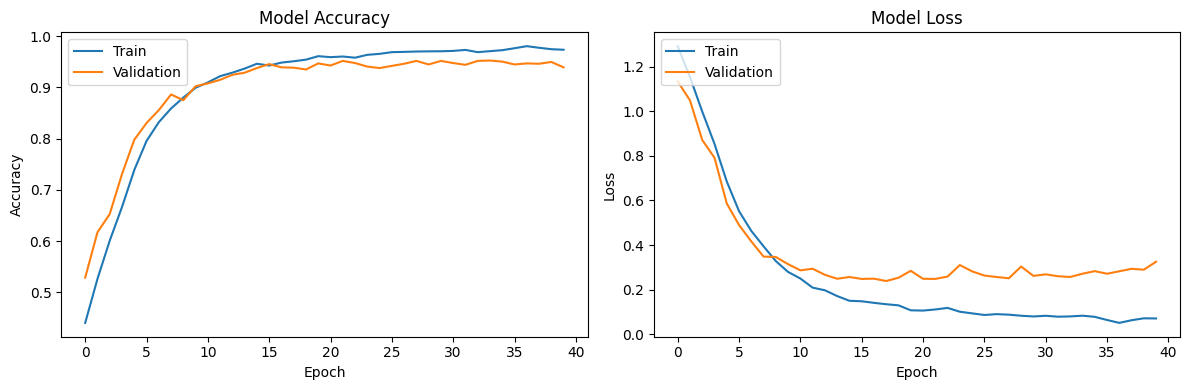

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


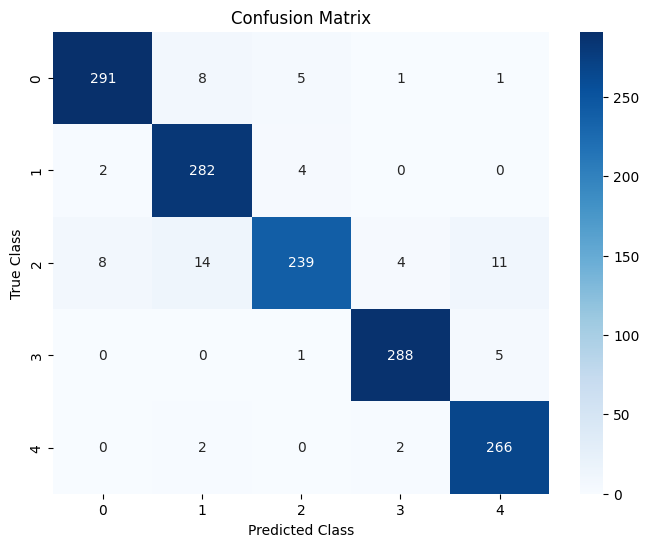

NameError: name 'classification_report' is not defined

In [9]:
# Predict the labels for the validation set
y_val_pred = model.predict(X_val)

# Convert one-hot encoded predictions and true labels back to class indices
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Generate the classification report
class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
class_report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names)

print("Classification Report:")
print(class_report)

Number of train samples: 2930
Number of validation samples: 366
Number of test samples: 366
Epoch 1/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3479 - loss: 3.0237

I0000 00:00:1730737240.661700     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 8 bytes spill stores, 8 bytes spill loads



180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.3480 - loss: 3.0173 - val_accuracy: 0.2001 - val_loss: 2.3617
Epoch 2/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3839 - loss: 1.3627 - val_accuracy: 0.2531 - val_loss: 1.8352
Epoch 3/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4242 - loss: 1.2583 - val_accuracy: 0.4651 - val_loss: 1.3761
Epoch 4/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4423 - loss: 1.2512 - val_accuracy: 0.5502 - val_loss: 1.0639
Epoch 5/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4911 - loss: 1.1678 - val_accuracy: 0.5453 - val_loss: 1.1037
Epoch 6/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5216 - loss: 1.0978 - val_accuracy: 0.6074 - val_loss: 0.9635
Epoch 7/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5219 - loss: 1.0740 - val_accuracy: 0.5739 - val_loss: 1.0784
Epoch 8/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5515 - loss: 1.0093 - val_accuracy: 0.61

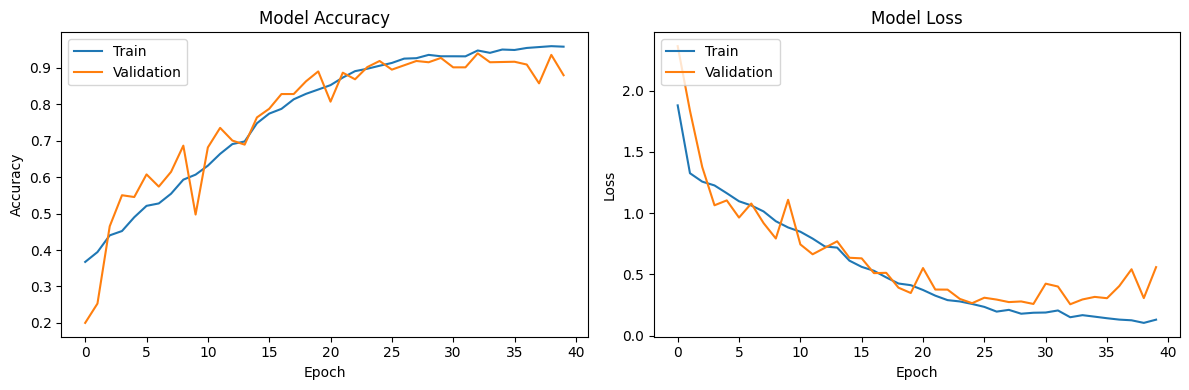

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


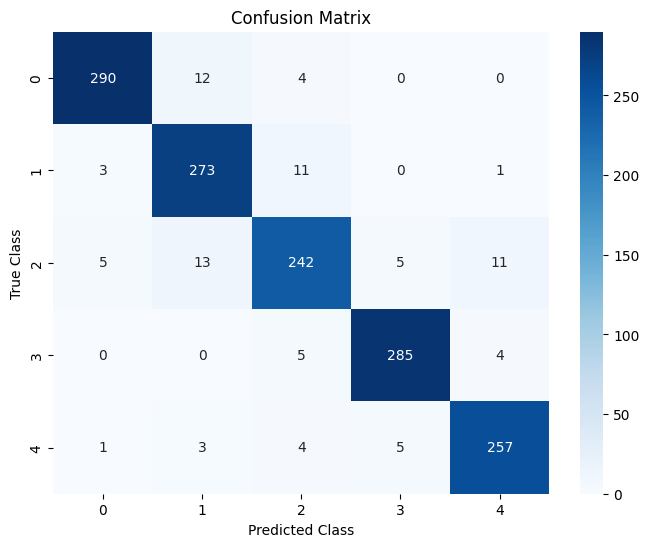

Classification Report:
                  precision    recall  f1-score   support

           No DR       0.97      0.95      0.96       306
            Mild       0.91      0.95      0.93       288
        Moderate       0.91      0.88      0.89       276
          Severe       0.97      0.97      0.97       294
Proliferative DR       0.94      0.95      0.95       270

        accuracy                           0.94      1434
       macro avg       0.94      0.94      0.94      1434
    weighted avg       0.94      0.94      0.94      1434



In [10]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

# Load the CSV files
train_data = pd.read_csv("/kaggle/input/aptos2019/train_1.csv")
valid_data = pd.read_csv("/kaggle/input/aptos2019/valid.csv")
test_data = pd.read_csv("/kaggle/input/aptos2019/test.csv")

# Print the number of samples in each dataset
print('Number of train samples:', train_data.shape[0])
print('Number of validation samples:', valid_data.shape[0])
print('Number of test samples:', test_data.shape[0])

# Define image directories
train_image_dir = "/kaggle/input/aptos2019/train_images/train_images"
val_image_dir = "/kaggle/input/aptos2019/val_images/val_images"
test_image_dir = "/kaggle/input/aptos2019/test_images/test_images"

# Function to load and preprocess images
def load_and_preprocess_image(image_id, img_size=(100, 100)):
    img_path = os.path.join(train_image_dir, f"{image_id}.png")
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    return img_array

# Prepare features and labels
X = np.array([load_and_preprocess_image(image_id) for image_id in train_data['id_code']])
y = train_data['diagnosis'].values

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y)  # Flatten images for SMOTE
X_resampled = X_resampled.reshape(-1, 100, 100, 3)  # Convert back to original image shape
y_resampled = to_categorical(y_resampled, num_classes=5)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define an Enhanced CNN model
def create_enhanced_cnn_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout to avoid overfitting
    model.add(Dense(5, activation='softmax'))  # Output layer for 5 classes

    return model

# Create the Enhanced CNN model
model = create_enhanced_cnn_model(input_shape=(100, 100, 3))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
]

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=40, 
                    batch_size=32, 
                    callbacks=callbacks)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)   
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Generate the classification report
class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
class_report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names)

print("Classification Report:")
print(class_report)
